In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# All skl imports go here
from sklearn import tree   # Decision Trees
from sklearn import svm    # svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import metrics
import sklearn as skl

# Data Loading

In [2]:
NUM_CLASSES = 6
CLASSES = ["sadnesss", "joy", "love", "anger", "fear"]

In [3]:
# Load all data
train_data = pd.read_csv("data/training_labse.csv")
test_data = pd.read_csv("data/test_labse.csv")
validation_data = pd.read_csv("data/validation_labse.csv")

# Separate X's and y's from each other
FEATURE_COLUMNS = [x for x in train_data if x.startswith("_e")]
LABEL_COLUMN = "label"

X_train = train_data[FEATURE_COLUMNS]
Y_train = train_data[LABEL_COLUMN]

X_test = test_data[FEATURE_COLUMNS]
Y_test = test_data[LABEL_COLUMN]

X_val = validation_data[FEATURE_COLUMNS]
Y_val = validation_data[LABEL_COLUMN]

# These are used to run cross validation
X_train_val = pd.concat([X_train, X_val]) 
Y_train_val = pd.concat([Y_train, Y_test])

# These are used to run val and test for Neural Nets
X_val_test = pd.concat([X_val, X_test])
Y_val_test = pd.concat([Y_val, Y_test])

In [4]:
# Perform pre-processing PCA on the training set
def perform_pca(dataset, target_variance):
    pca = PCA(n_components= target_variance)

    # Need to standardize the data frirst
    standardized = (dataset - dataset.mean(axis=0)) / dataset.std(axis = 0)

    pca.fit(X=standardized)
    dataset_reduced = pca.fit_transform(X=standardized)

    return pca, dataset_reduced

In [5]:
TARGET_EXPLAINED_VARIANCE = 0.999999

pca_train, X_train_reduced = perform_pca(X_train, TARGET_EXPLAINED_VARIANCE)
X_val_reduced = pca_train.transform(X_val)
X_test_redced = pca_train.transform(X_test)
X_train_val_reduced = pca_train.transform(X_train_val)
X_val_test_reduced = pca_train.transform(X_val_test)

print(f"{pca_train.n_components_} components for training")

768 components for training


In [6]:
X_train_unreduced = X_train.to_numpy()
X_val_unreduced = X_val.to_numpy()
X_test_unreduced = X_test.to_numpy()
X_train_val_unreduced = X_train_val.to_numpy()
X_val_test_unreduced = X_val_test.to_numpy()


In [7]:
X_train_used = X_train_unreduced
X_val_used = X_val_unreduced
X_test_used = X_test_unreduced
X_train_val_used = X_train_val_unreduced 
X_val_test_used = X_val_test_unreduced

# Forward Feature Selection

In [10]:
# Initialize feature selector 

def forward_select(model, X, y, k): 
    sfs = SequentialFeatureSelector(estimator=model, n_features_to_select=k)
    sfs.fit(X, y)
    return sfs.get_feature_names_out(), sfs.transform(X)

def forward_select_and_fit(model, X_train, Y_train, k, X_test, Y_test):
    model : tree.DecisionTreeClassifier = skl.base.clone(model)
    _, Xt = forward_select(model, X_train, Y_train, k)
    model.fit(Xt, Y_train)

    # TODO: Run tests here

# K-Folds Cross Validation

In [8]:

def k_folds_x_val(model, X, y, k =  5): 
    results = cross_validate(model, X, y, cv=k, scoring=["accuracy"])
    mean_accuracy = results['test_accuracy'].mean()
    print(f"Mean Accuracy: {mean_accuracy}")
    return mean_accuracy, 

def get_cmat(model, X, y):
    y_pred = model.predict(X)
    return confusion_matrix(y, y_pred, normalize="pred")

def get_metrics(model, X, y):
    y_pred = model.predict(X)
    return accuracy_score(y, y_pred), f1_score(y, y_pred, average="weighted")

# Grid Search Hyperparameter Optimization

In [9]:
def gridSearchHPO(model, search_space):
    grid_search = GridSearchCV(estimator=model,
                                param_grid=search_space,
                                scoring='accuracy',
                                cv=5,
                                verbose=3,
                                error_score='raise',
                                n_jobs=-1,  # -1 means max amount
                                )
    return grid_search

# Decision Trees

In [11]:
decision_tree_model = tree.DecisionTreeClassifier(
    criterion ='entropy', 
    splitter = 'best',
    max_depth = 256, 
    max_features = 'sqrt',
    max_leaf_nodes = 80,
)

In [ ]:
# ['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 
# 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter']
dt_search_space = {
    # 'ccp_alpha':[0.1, 0.2, 0.4, 0.5],
    'max_leaf_nodes':[71, 72, 73, 74, 75, 76, 77, 78, 79, 80], 
    # 'min_impurity_decrease':[1.0, 0.5, 1.5, 2.0], # float
    # 'min_weight_fraction_leaf':[0.1, 0.2, 0.4, 0.5],
    'max_depth':[255, 256, 257, 258, 259, 260], 
    # 'max_features':["log2", "sqrt"], 
    # 'min_samples_leaf':[0.1, 0.2, 0.4, 0.5], 
    # 'min_samples_split':[0.1, 0.2, 0.4, 0.5]
    }

model_dt = decision_tree_model.fit(X_train_used, Y_train)

gridsearch_dt = gridSearchHPO(model=model_dt, search_space=dt_search_space)

In [ ]:
gridsearch_dt.fit(X_train_used, Y_train)

In [ ]:
print("Best Score: {}".format(gridsearch_dt.best_score_))
print("Best params: {}".format(gridsearch_dt.best_params_))

### With Feature Select

In [12]:
decision_tree_model_reduced : tree.DecisionTreeClassifier = skl.base.clone(decision_tree_model)
Xt = forward_select(decision_tree_model_reduced, X_train_val_used, Y_train_val, 30)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

# K Nearest Neighbors

In [42]:
k_nearest_model = KNeighborsClassifier(
    n_jobs=-1,
    weights="uniform",
    algorithm="ball_tree",
    metric="cityblock",
    leaf_size=2,
    n_neighbors=60
)

In [49]:
knn_search_space = {
    "n_neighbors": [60],
    # "weights": ['uniform', 'distance'], # Uniform
    # "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'], # ball tree
    # "metric": ['cityblock', 'euclidean', 'l1', 'l2', 'manhattan', 'minkowski'], # city block
    # "leaf_size": [2], # 2
}

In [50]:
model_knn = k_nearest_model.fit(X_train, Y_train)

gridsearch_knn = gridSearchHPO(model=model_knn, search_space=knn_search_space)

In [51]:
gridsearch_knn.fit(X_train, Y_train)

print("Best Score: {}".format(gridsearch_knn.best_score_))
print("Best params: {}".format(gridsearch_knn.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.5619375
Best params: {'n_neighbors': 60}


In [ ]:
# With feature selection

forward_select_and_fit(model_knn, X_train_val_used, Y_train_val, 30, X_test_used, Y_test)

# SVMs

In [ ]:
svm_classifier = svm.SVC(max_iter=-1)

#Train the model using the training sets
svm_classifier.fit(X_train, Y_train)

#Predict the response for test dataset
# k_folds_x_val(svm_classifier)

In [ ]:
svm_search_space={
    'C': [1],
    'kernel': ['poly'], # poly - 'rbf', 'linear', 'sigmoid' 
    'degree': [3],  # 3
    'gamma': ['scale'], #'auto',  1, 0.1, 0.01, 0.001, 0.0001, 
    'coef0': [0.1], 
    'shrinking': [True], 
    'probability': [False], 
    'tol': [0.1],  
    'class_weight': [None], 
    'decision_function_shape': ['ovr'], # 'ovo'
}

gridsearch_svm = gridSearchHPO(svm_classifier, svm_search_space)

In [ ]:
gridsearch_svm.fit(X_train, Y_train)

In [ ]:
print("Best Score: {}".format(gridsearch_svm.best_score_))
print("Best params: {}".format(gridsearch_svm.best_params_))

In [ ]:
# With forward selection 

forward_select_and_fit(svm_classifier, X_train_val_used, Y_train_val, 30, X_test_used, Y_test)

# Pytorch Setup

In [10]:
# Pytorch specific constants
from torch.utils.data import TensorDataset, DataLoader
from utils.neuralnet import NeuralNetwork
from utils.trainer import training_loop, evaluate
import torch

BATCH_SIZE = 16
LEARNING_RATE = 1e-3

# MLP

In [ ]:
mlp = MLPClassifier([], 'relu', solver="adam")
mlp.fit(X_train_used, Y_train)

In [ ]:
k_folds_x_val(mlp, X_train_val_used, Y_train_val)

In [ ]:
cmat = get_cmat(mlp, X_val_test_used, Y_val_test)
print(get_metrics(mlp, X_val_test_used, Y_val_test))
plt.matshow(cmat)
plt.show()

In [ ]:
# With feature selection
forward_select_and_fit(mlp, X_train_val_used, Y_train_val, 30, X_test_used, Y_test)

In [8]:
from utils.neuralnet import NeuralNetwork
from utils.trainer import training_loop, evaluate

In [11]:
# For pytorch specifically we should load data to the provided dataloader and dataset classes. 
# This handles the batching for us.

pt_train_set = TensorDataset(torch.Tensor(X_train_used), torch.Tensor(Y_train.to_numpy()).long())
pt_val_set = TensorDataset(torch.Tensor(X_val_used), torch.Tensor(Y_val.to_numpy()).long())
pt_test_set = TensorDataset(torch.Tensor(X_test_used), torch.Tensor(Y_test.to_numpy()).long())
pt_val_test_set = TensorDataset(torch.Tensor(X_val_test_used), torch.Tensor(Y_val_test.to_numpy()).long())

pt_train_loader = DataLoader(
                    dataset=pt_train_set, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                )
pt_val_loader = DataLoader(
                    dataset=pt_val_set, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                )
pt_test_loader = DataLoader(
                    dataset=pt_test_set, 
                    batch_size=1, 
                    shuffle=True,
                )

pt_val_test_loader = DataLoader(
                    dataset=pt_val_test_set, 
                    batch_size=1, 
                    shuffle=True,
                )

In [14]:
# Initialize neural network
mlp = NeuralNetwork(X_train_reduced.shape[1], [50, 50, 50], NUM_CLASSES)

training_loop(mlp, pt_train_loader, pt_val_loader, 1000, LEARNING_RATE)

Epoch 1
train_loss = 1.3213, val_loss = 1.1576
Epoch 2
train_loss = 1.4500, val_loss = 1.1250
Epoch 3
train_loss = 1.0999, val_loss = 1.1194
Epoch 4
train_loss = 1.0429, val_loss = 1.0963
Epoch 5
train_loss = 1.1543, val_loss = 1.0868
Epoch 6
train_loss = 1.1060, val_loss = 1.0864
Epoch 7
train_loss = 1.5329, val_loss = 1.0933
Epoch 8
train_loss = 0.9416, val_loss = 1.0816
Epoch 9
train_loss = 1.1846, val_loss = 1.0769
Epoch 10
train_loss = 1.3218, val_loss = 1.0625
Epoch 11
train_loss = 0.9499, val_loss = 1.0718
Epoch 12
train_loss = 1.0959, val_loss = 1.0730
Epoch 13
train_loss = 0.7654, val_loss = 1.0552
Epoch 14
train_loss = 1.0357, val_loss = 1.0547
Epoch 15
train_loss = 1.0753, val_loss = 1.0556
Epoch 16
train_loss = 1.1946, val_loss = 1.0491
Epoch 17
train_loss = 0.7964, val_loss = 1.0302
Epoch 18
train_loss = 1.4036, val_loss = 1.0297
Epoch 19
train_loss = 1.1641, val_loss = 1.0284
Epoch 20
train_loss = 0.8317, val_loss = 1.0289
Epoch 21
train_loss = 0.7687, val_loss = 1.0286
E

loss = 1.7903
accuracy = 0.6178
f1 = 0.5876
[[0.55121043 0.07253565 0.09009009 0.2183908  0.16076294 0.        ]
 [0.10180012 0.71047737 0.36036036 0.06130268 0.08174387 0.08108108]
 [0.044072   0.12275263 0.46846847 0.02298851 0.02452316 0.02702703]
 [0.16883923 0.04277743 0.04504505 0.61302682 0.11989101 0.        ]
 [0.10738672 0.0216987  0.01801802 0.08429119 0.53950954 0.16216216]
 [0.0266915  0.02975821 0.01801802 0.         0.07356948 0.72972973]]


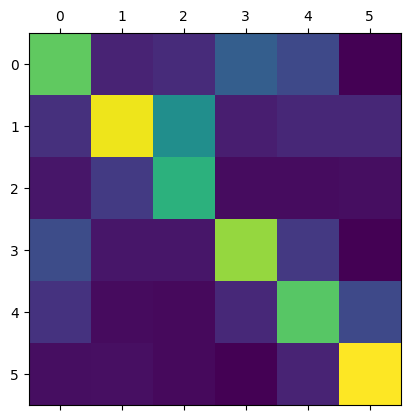

In [15]:
_, _, _, cmat = evaluate(model=mlp, val_dl=pt_val_test_loader)
print(cmat)
plt.matshow(cmat)
plt.show()